In [1]:
import pandas as pd
import numpy as np

# Load (adjust paths)
X = pd.read_csv("data/X_discharge_v1.csv")
y = pd.read_csv("data/y_readmit30_v1.csv")

# If y is a single column, rename it to readmit_30 if needed
# Example: y.columns -> ['readmit_30'] or something similar
df = X.copy()
df["readmit_30"] = y.iloc[:, 0].astype(int)

df.shape, df["readmit_30"].mean()

((101766, 42), np.float64(0.11159915885462728))

In [2]:
# Class imbalance
readmit_rate = df["readmit_30"].mean()
print("readmit_30 rate:", readmit_rate)

# Missingness (top 10)
missing = df.isna().mean().sort_values(ascending=False)
missing.head(10)

readmit_30 rate: 0.11159915885462728


race             0.022336
examide          0.000000
glyburide        0.000000
tolbutamide      0.000000
pioglitazone     0.000000
rosiglitazone    0.000000
acarbose         0.000000
miglitol         0.000000
troglitazone     0.000000
tolazamide       0.000000
dtype: float64

In [3]:
# Plot readmit rate by group (with n)

import matplotlib.pyplot as plt

def plot_rate_by_group(df, group_col, target="readmit_30", min_n=50, sort=True):
    tmp = (
        df.groupby(group_col)[target]
          .agg(n="size", rate="mean")
          .reset_index()
    )
    tmp = tmp[tmp["n"] >= min_n].copy()
    if sort:
        tmp = tmp.sort_values("rate", ascending=False)

    plt.figure()
    plt.bar(tmp[group_col].astype(str), tmp["rate"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Readmission rate")
    plt.title(f"Readmission rate by {group_col} (n≥{min_n})")
    plt.tight_layout()
    return tmp

,time_in_hospital,n,rate
0,1,14208,0.081785
1,2,17224,0.099396
2,3,17756,0.106668
3,4,13924,0.118070
4,5,9966,0.120309


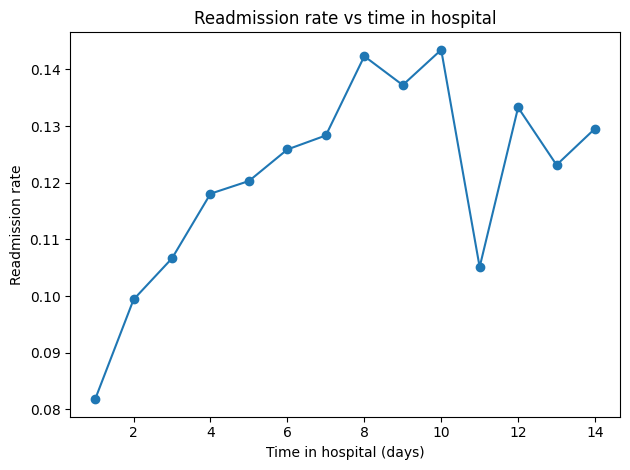

In [4]:
# Plot 1: Readmission rate vs time_in_hospital 

tmp1 = (
    df.groupby("time_in_hospital")["readmit_30"]
      .agg(n="size", rate="mean")
      .reset_index()
)

plt.figure()
plt.plot(tmp1["time_in_hospital"], tmp1["rate"], marker="o")
plt.xlabel("Time in hospital (days)")
plt.ylabel("Readmission rate")
plt.title("Readmission rate vs time in hospital")
plt.tight_layout()
tmp1.head()

In [5]:
# Readmission rate increases with longer stays (roughly monotonic for common stay lengths), suggesting length-of-stay is a strong severity proxy.

,number_inpatient,n,rate
0,0,67630,0.084371
1,1,19521,0.129245
2,2,7566,0.174333
3,3,3411,0.202873
4,4,1622,0.236128


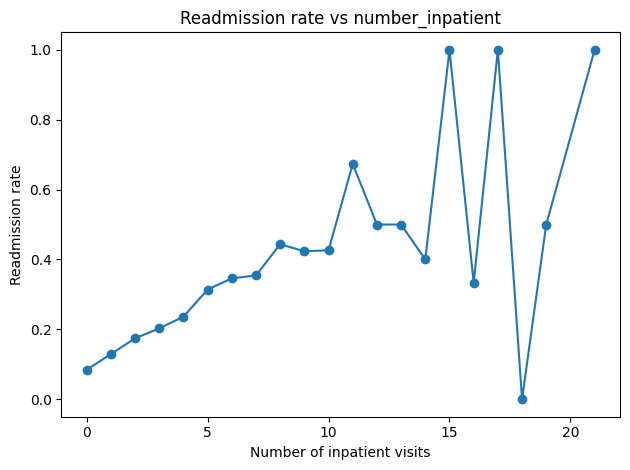

In [6]:
# Plot 2: Readmission rate vs number_inpatient

tmp2 = (
    df.groupby("number_inpatient")["readmit_30"]
      .agg(n="size", rate="mean")
      .reset_index()
)

plt.figure()
plt.plot(tmp2["number_inpatient"], tmp2["rate"], marker="o")
plt.xlabel("Number of inpatient visits")
plt.ylabel("Readmission rate")
plt.title("Readmission rate vs number_inpatient")
plt.tight_layout()
tmp2.sort_values("number_inpatient").head()

In [ ]:
# Higher prior inpatient utilization correlates with higher readmission risk; heavy utilizers concentrate risk.

/var/folders/3x/f1qflpnn34b68r8pysx3plg00000gn/T/ipykernel_9151/3681615828.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("num_meds_bin")["readmit_30"]


,num_meds_bin,n,rate
0,0-5,5066,0.074812
1,6-10,20795,0.094494
2,11-15,29384,0.109107
3,16-20,22641,0.121726
4,21-30,18643,0.128735
5,31-40,3876,0.128225
6,41-60,1264,0.110759
7,61+,97,0.144330


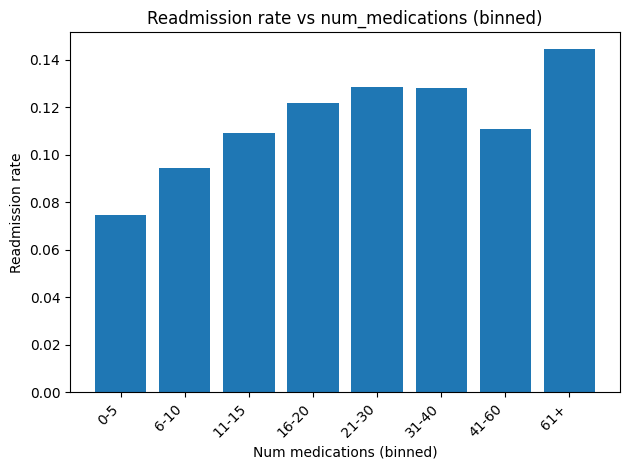

In [7]:
# Plot 3: Readmission rate vs num_medications

bins = [0,5,10,15,20,30,40,60,1000]
labels = ["0-5","6-10","11-15","16-20","21-30","31-40","41-60","61+"]

df["num_meds_bin"] = pd.cut(df["num_medications"], bins=bins, labels=labels, right=True, include_lowest=True)

tmp3 = (
    df.groupby("num_meds_bin")["readmit_30"]
      .agg(n="size", rate="mean")
      .reset_index()
)

plt.figure()
plt.bar(tmp3["num_meds_bin"].astype(str), tmp3["rate"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Num medications (binned)")
plt.ylabel("Readmission rate")
plt.title("Readmission rate vs num_medications (binned)")
plt.tight_layout()
tmp3

In [ ]:
# Readmission rate rises with medication count, consistent with comorbidity/complexity (however, watch for diminishing returns at the extreme tail).

,age,n,rate
0,[0-10),161,0.018634
1,[10-20),691,0.057887
2,[20-30),1657,0.142426
3,[30-40),3775,0.112318
4,[40-50),9685,0.106040
5,[50-60),17256,0.096662
6,[60-70),22483,0.111284
7,[70-80),26068,0.117731
8,[80-90),17197,0.120835
9,[90-100),2793,0.110992


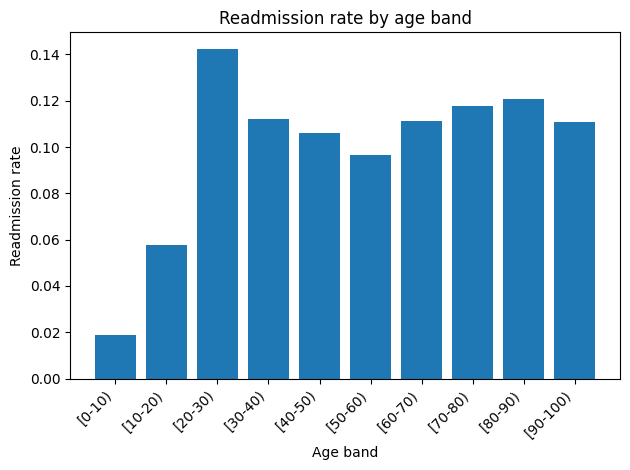

In [8]:
# Plot 4: Readmission rate vs age band

tmp4 = (
    df.groupby("age")["readmit_30"]
      .agg(n="size", rate="mean")
      .reset_index()
      .sort_values("age")
)

plt.figure()
plt.bar(tmp4["age"].astype(str), tmp4["rate"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Age band")
plt.ylabel("Readmission rate")
plt.title("Readmission rate by age band")
plt.tight_layout()
tmp4

In [ ]:
# Older age groups show higher baseline readmission rates; differences may reflect both underlying risk and discharge complexity.
# Also note small-n bands where rates are noisy.

,insulin,n,rate
0,Down,12218,0.138975
3,Up,11316,0.129905
2,Steady,30849,0.111284
1,No,47383,0.100374


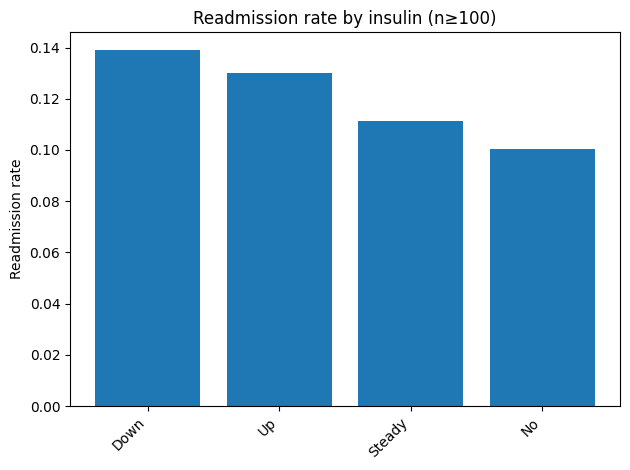

In [11]:
# Plot 5: Readmission rate vs insulin

tmp5 = plot_rate_by_group(df, "insulin", min_n=100)
tmp5

In [ ]:
# Some insulin categories show noticeably different readmission rates, implying diabetes treatment status is informative. 
# However, it could reflect disease severity rather than treatment effect.

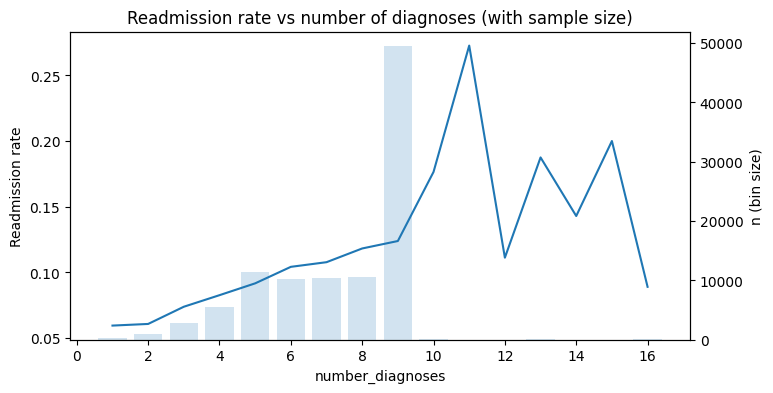

In [12]:
# Plot #6: Readmission rate vs number of diagnoses

col = "number_diagnoses"

tmp = (df.groupby(col)["readmit_30"]
         .agg(n="size", readmit_rate="mean")
         .reset_index()
         .sort_values(col))

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(tmp[col], tmp["readmit_rate"])
ax1.set_xlabel(col)
ax1.set_ylabel("Readmission rate")

# show n as bars on a second axis so you don't overtrust tiny bins
ax2 = ax1.twinx()
ax2.bar(tmp[col], tmp["n"], alpha=0.2)
ax2.set_ylabel("n (bin size)")

plt.title("Readmission rate vs number of diagnoses (with sample size)")
plt.show()

In [ ]:
# Readmission rate increases with diagnosis count; this behaves like a “complexity” gradient and supports using diagnosis count as a predictive feature.

In [ ]:
# NOTE FOR ALL OF THE ABOVE: Some bins have small n (especially extremes), so those rates are noisier; conclusions are strongest where n is large.